In [1]:
import algos
import bandit
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations
import utils
import pickle

plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100

N_TASKS = 500
N_ARMS = 10
OPT_SIZE = 9 # >1
HORIZON = 270
N_EXPS = 5 #No. of repeat experiments
GAP_THRESHOLD = np.sqrt(N_ARMS*np.log(N_TASKS)/HORIZON)
gap = min(1,GAP_THRESHOLD*1.4)
kwargs = {'task_cache_step': 20,
          'gap_constrain':gap,
          'plot_var': True,
          'is_adversarial': True,
          'timeout': 5, # maximum duration for each roll-outs. Unit = minute. -1 = unlimited
          'quiet': True,
          'skip_list': ['PMML']
         }
assert N_ARMS<=HORIZON, f"The number of arm ({N_ARMS}) must be smaller than the horizon ({HORIZON})"
assert OPT_SIZE<=N_ARMS, f"The subset size ({OPT_SIZE}) must be smaller than the number of arm ({N_ARMS})"
print(f'GAP_THRESHOLD = {GAP_THRESHOLD}, actual gap = {gap}')

GAP_THRESHOLD = 0.4797610554348206, actual gap = 0.6716654776087488


## Regret vs Number of tasks

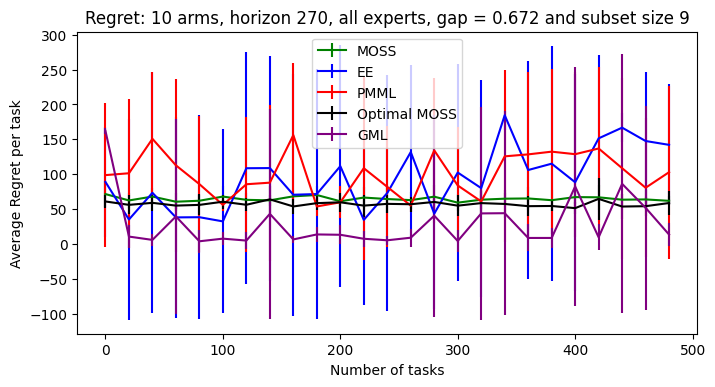

In [3]:
# Plot from loaded cache file
X = np.arange(N_TASKS)
gap = kwargs['gap_constrain']
regret_dict = pickle.load(open("results/tasks.p", "rb"))
# regret_dict = pickle.load(open("results/tasks_cache.p", "rb"))
n_experts=10
title = f'Regret: {N_ARMS} arms, horizon {HORIZON}, all experts, gap = {gap:.3f} and subset size {OPT_SIZE}'
xlabel, ylabel = 'Number of tasks', 'Average Regret per task'
indices = np.arange(0, X.shape[0], kwargs['task_cache_step']).astype(int)
utils.plot(X[indices], regret_dict, title, xlabel, ylabel, **kwargs)

## Regret vs Horizon

  0%|          | 0/5 [00:00<?, ?it/s]

gap = 0.4797610554348206
opt_indices = [1 2 3 4 5 6 7 8 9]
is_out_of_set = True, q = 0.015761659061178417
is_out_of_set = True, q = 0.015252642693697784
is_out_of_set = True, q = 0.014766972562247401
is_out_of_set = True, q = 0.018177566559224034
is_out_of_set = True, q = 0.01795638700629443
is_out_of_set = True, q = 0.017540110335622333
is_out_of_set = True, q = 0.02400926823578076
is_out_of_set = True, q = 0.023188227920894117
is_out_of_set = True, q = 0.01617473001882181
is_out_of_set = True, q = 0.016190092519117065
is_out_of_set = True, q = 0.016205499736436195
is_out_of_set = True, q = 0.016220951889847113
is_out_of_set = True, q = 0.01623644919992995
is_out_of_set = True, q = 0.016251991888790562
is_out_of_set = True, q = 0.016267580180074133
is_out_of_set = True, q = 0.016283214298979002
is_out_of_set = True, q = 0.01586465779769391
is_out_of_set = True, q = 0.016958879031731
is_out_of_set = True, q = 0.021004900420735006
is_out_of_set = True, q = 0.023838063411193804
is_out_of

 20%|██        | 1/5 [02:40<10:43, 160.93s/it]

is_out_of_set = True, q = 0.07606797113428744
gap = 0.4797610554348206
opt_indices = [1 2 3 4 5 6 7 8 9]
is_out_of_set = True, q = 0.015291221845756346
is_out_of_set = True, q = 0.014755163138464492
is_out_of_set = True, q = 0.014766972562247401
is_out_of_set = True, q = 0.017813258235665378
is_out_of_set = True, q = 0.017316876287440598
is_out_of_set = True, q = 0.017294517919793168
is_out_of_set = True, q = 0.01874803931648247
is_out_of_set = True, q = 0.0190773731537743
is_out_of_set = True, q = 0.01617473001882181
is_out_of_set = True, q = 0.016190092519117065
is_out_of_set = True, q = 0.016205499736436195
is_out_of_set = True, q = 0.0149907707043377
is_out_of_set = True, q = 0.01542445896266989
is_out_of_set = True, q = 0.018213040505602685
is_out_of_set = True, q = 0.01802357129502721
is_out_of_set = True, q = 0.019172321172815
is_out_of_set = True, q = 0.022560602193167193
is_out_of_set = True, q = 0.022748168671389946
is_out_of_set = True, q = 0.029672380554535943
is_out_of_set

 40%|████      | 2/5 [05:23<08:05, 161.78s/it]

gap = 0.4797610554348206
opt_indices = [0 2 3 4 5 6 7 8 9]
is_out_of_set = True, q = 0.014833043887030965
is_out_of_set = True, q = 0.015602366232412151
is_out_of_set = True, q = 0.029267064132415067
is_out_of_set = True, q = 0.0478698244180482
is_out_of_set = True, q = 0.01617473001882181
is_out_of_set = True, q = 0.015812901093883953
is_out_of_set = True, q = 0.015882025910755534
is_out_of_set = True, q = 0.01726510915400473
is_out_of_set = True, q = 0.018034320218380362
is_out_of_set = True, q = 0.01768362243432606
is_out_of_set = True, q = 0.01845108605916978
is_out_of_set = True, q = 0.022984662216001057
is_out_of_set = True, q = 0.022199502359942364
is_out_of_set = True, q = 0.022090376401524687
is_out_of_set = True, q = 0.0231947264487656
is_out_of_set = True, q = 0.024330161470980164
is_out_of_set = True, q = 0.03257352643570291
is_out_of_set = True, q = 0.03320917808207517
is_out_of_set = True, q = 0.0657271916939293
is_out_of_set = True, q = 0.014932822507922428
is_out_of_set

 60%|██████    | 3/5 [08:02<05:20, 160.47s/it]

gap = 0.4797610554348206
opt_indices = [0 1 2 3 4 5 6 7 8]
is_out_of_set = True, q = 0.015545352970806184
is_out_of_set = True, q = 0.015235782629578342
is_out_of_set = True, q = 0.014850759048688307
is_out_of_set = True, q = 0.014547261911117042
is_out_of_set = True, q = 0.015658789600999652
is_out_of_set = True, q = 0.015909323582174964
is_out_of_set = True, q = 0.015335313252332774
is_out_of_set = True, q = 0.016188292032008875
is_out_of_set = True, q = 0.01617473001882181
is_out_of_set = True, q = 0.016190092519117065
is_out_of_set = True, q = 0.016205499736436195
is_out_of_set = True, q = 0.016220951889847113
is_out_of_set = True, q = 0.01623644919992995
is_out_of_set = True, q = 0.01713179995867604
is_out_of_set = True, q = 0.01679833696761723
is_out_of_set = True, q = 0.01797602129699952
is_out_of_set = True, q = 0.018751356886679383
is_out_of_set = True, q = 0.0209370038631394
is_out_of_set = True, q = 0.02137539580209021
is_out_of_set = True, q = 0.0217229815584662
is_out_of_s

 80%|████████  | 4/5 [10:40<02:39, 159.42s/it]

is_out_of_set = True, q = 0.09761861624478618
gap = 0.4797610554348206
opt_indices = [0 1 2 3 4 5 6 8 9]
is_out_of_set = True, q = 0.017001605857554503
is_out_of_set = True, q = 0.016340954311063784
is_out_of_set = True, q = 0.017992931261595745
is_out_of_set = True, q = 0.018421811076307557
is_out_of_set = True, q = 0.020486831580847475
is_out_of_set = True, q = 0.021649964302073225
is_out_of_set = True, q = 0.021694673531053404
is_out_of_set = True, q = 0.02179594902982599
is_out_of_set = True, q = 0.01617473001882181
is_out_of_set = True, q = 0.016190092519117065
is_out_of_set = True, q = 0.015761659061178417
is_out_of_set = True, q = 0.016076308664369356
is_out_of_set = True, q = 0.01589719926613111
is_out_of_set = True, q = 0.01550244492313509
is_out_of_set = True, q = 0.01607942374931533
is_out_of_set = True, q = 0.023309903134756012
is_out_of_set = True, q = 0.023701464756975817
is_out_of_set = True, q = 0.02663190274123316
is_out_of_set = True, q = 0.01617473001882181
is_out_of

100%|██████████| 5/5 [13:18<00:00, 159.64s/it]

is_out_of_set = True, q = 0.0616253709839075


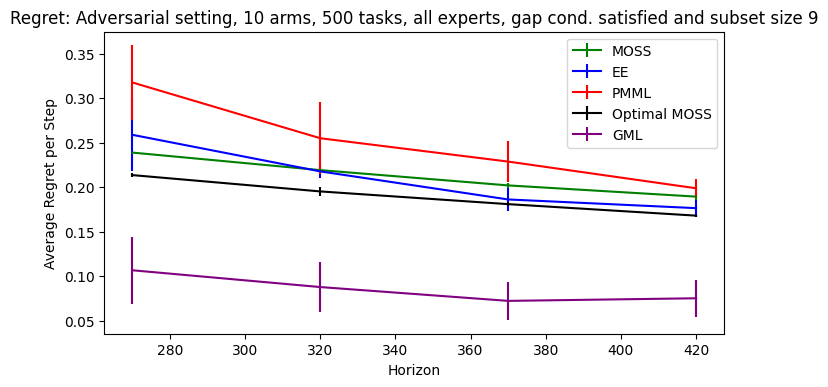

In [4]:
horizon_list = np.arange(270, 430, 50)
(X_h, regret_dict_h, title, xlabel, ylabel) = \
utils.horizon_exp(N_EXPS, N_TASKS, N_ARMS, OPT_SIZE, 
                  horizon_list = horizon_list, **kwargs)
pickle.dump(regret_dict_h, open("results/horizon.p", "wb"))
regret_dict_h = pickle.load(open("results/horizon.p", "rb"))
pass

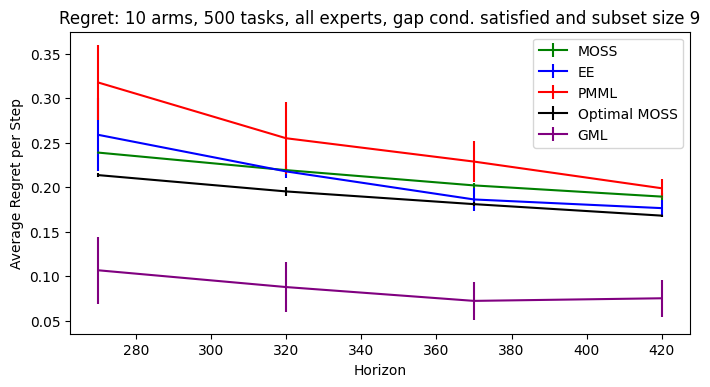

In [5]:
# Plot from loaded cache file
X_h = np.arange(270, 430, 50)
regret_dict_h = pickle.load(open("results/horizon.p", "rb"))
title = f'Regret: {N_ARMS} arms, {N_TASKS} tasks, all experts, gap cond. satisfied and subset size {OPT_SIZE}'
xlabel, ylabel = 'Horizon', 'Average Regret per Step'
utils.plot(X_h, regret_dict_h, title, xlabel, ylabel, **kwargs)

## Regret vs # of arm

In [5]:
n_arms_list = np.arange(3,8,1)
(X_b, regret_dict_b, title, xlabel, ylabel) = \
utils.arms_exp(N_EXPS, N_TASKS, HORIZON, OPT_SIZE, n_arms_list, **kwargs)
pickle.dump(regret_dict_b, open("results/arms.p", "wb"))
regret_dict_h = pickle.load(open("results/arms.p", "rb"))
pass

  0%|          | 0/5 [00:00<?, ?it/s]

opt_indices = [1 2]
opt_indices = [0 3]
opt_indices = [3 4]
opt_indices = [1 2]
WARNING (Phased Elimination): phase 1 duration (120) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (120) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (120) is larger than the horizon (100) => increase horizon and/or change n_arms.
opt_indices = [4 6]
WARNING (Phased Elimination): phase 1 duration (147) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (147) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (147) is larger than the horizon (100) => increase horizon and/or change n_arms.


 20%|██        | 1/5 [01:02<04:08, 62.02s/it]

opt_indices = [0 1]
opt_indices = [1 3]
opt_indices = [2 3]
opt_indices = [4 5]
WARNING (Phased Elimination): phase 1 duration (120) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (120) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (120) is larger than the horizon (100) => increase horizon and/or change n_arms.
opt_indices = [1 2]
WARNING (Phased Elimination): phase 1 duration (147) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (147) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (147) is larger than the horizon (100) => increase horizon and/or change n_arms.


 40%|████      | 2/5 [02:03<03:05, 61.88s/it]

opt_indices = [1 2]
opt_indices = [1 2]
opt_indices = [2 4]
opt_indices = [4 5]
WARNING (Phased Elimination): phase 1 duration (120) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (120) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (120) is larger than the horizon (100) => increase horizon and/or change n_arms.
opt_indices = [0 4]
WARNING (Phased Elimination): phase 1 duration (147) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (147) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (147) is larger than the horizon (100) => increase horizon and/or change n_arms.


 60%|██████    | 3/5 [03:05<02:04, 62.01s/it]

opt_indices = [1 2]
opt_indices = [0 1]
opt_indices = [1 3]
opt_indices = [1 2]
WARNING (Phased Elimination): phase 1 duration (120) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (120) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (120) is larger than the horizon (100) => increase horizon and/or change n_arms.
opt_indices = [1 4]
WARNING (Phased Elimination): phase 1 duration (147) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (147) is larger than the horizon (100) => increase horizon and/or change n_arms.
WARNING (Phased Elimination): phase 1 duration (147) is larger than the horizon (100) => increase horizon and/or change n_arms.


 60%|██████    | 3/5 [04:06<02:44, 82.08s/it]


KeyboardInterrupt: 

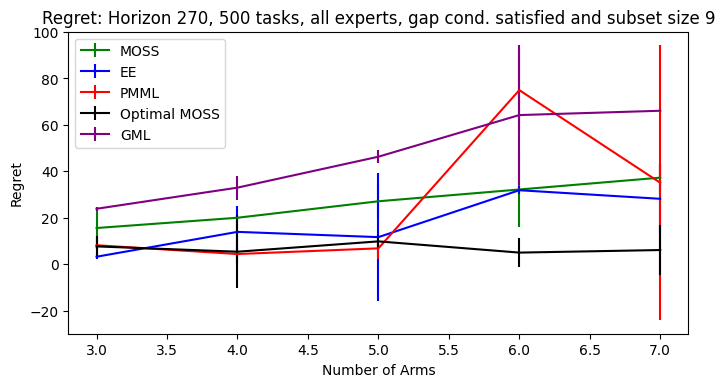

In [8]:
# # Plot from loaded cache file
# title = f'Regret: Horizon {HORIZON}, {N_TASKS} tasks, all experts, gap cond. satisfied and subset size {OPT_SIZE}'
# xlabel, ylabel = 'Number of Arms', 'Regret'
# X_b = np.arange(3,8,1)
# regret_dict_b = pickle.load(open("results/arms.p", "rb"))
# utils.plot(X_b, regret_dict_b, title, xlabel, ylabel, **kwargs)

## Regret vs subset size

  0%|          | 0/5 [00:00<?, ?it/s]

opt_indices = [2 9]
is_out_of_set = True, q = 0.016628540034516706
is_out_of_set = True, q = 0.01617473001882181
is_out_of_set = True, q = 0.016190092519117065
is_out_of_set = True, q = 0.016205499736436195
is_out_of_set = True, q = 0.016220951889847113
is_out_of_set = True, q = 0.01623644919992995
is_out_of_set = True, q = 0.016251991888790562
is_out_of_set = True, q = 0.016267580180074133
is_out_of_set = True, q = 0.014961710626539549
is_out_of_set = True, q = 0.015545352970806184
is_out_of_set = True, q = 0.01586465779769391
is_out_of_set = True, q = 0.01670926849369044
is_out_of_set = True, q = 0.018243703838841448
is_out_of_set = True, q = 0.02058118993681061
is_out_of_set = True, q = 0.024787510575453028
is_out_of_set = True, q = 0.027257256055630417
is_out_of_set = True, q = 0.02792995421439397
is_out_of_set = True, q = 0.029686514668406782
is_out_of_set = True, q = 0.031258622419374195
is_out_of_set = True, q = 0.03852481586008811
is_out_of_set = True, q = 0.01617473001882181
i

 20%|██        | 1/5 [02:33<10:14, 153.51s/it]

is_out_of_set = True, q = 0.06638762449463124
is_out_of_set = True, q = 0.10902106269257426
opt_indices = [0 9]
is_out_of_set = True, q = 0.01556166958812076
is_out_of_set = True, q = 0.01617473001882181
is_out_of_set = True, q = 0.016190092519117065
is_out_of_set = True, q = 0.016205499736436195
is_out_of_set = True, q = 0.016220951889847113
is_out_of_set = True, q = 0.01623644919992995
is_out_of_set = True, q = 0.016251991888790562
is_out_of_set = True, q = 0.016267580180074133
is_out_of_set = True, q = 0.01775813330822324
is_out_of_set = True, q = 0.01877264249919308
is_out_of_set = True, q = 0.01617473001882181
is_out_of_set = True, q = 0.016190092519117065
is_out_of_set = True, q = 0.016205499736436195
is_out_of_set = True, q = 0.014947245179371285
is_out_of_set = True, q = 0.015353558833285375
is_out_of_set = True, q = 0.015512876547243
is_out_of_set = True, q = 0.01645119485854669
is_out_of_set = True, q = 0.01761286629182131
is_out_of_set = True, q = 0.01617473001882181
is_out_

 40%|████      | 2/5 [05:04<07:36, 152.22s/it]

is_out_of_set = True, q = 0.08117406627283744
is_out_of_set = True, q = 0.10902106269257426
opt_indices = [1 2]
is_out_of_set = True, q = 0.016588622569462707
is_out_of_set = True, q = 0.01617473001882181
is_out_of_set = True, q = 0.016190092519117065
is_out_of_set = True, q = 0.016205499736436195
is_out_of_set = True, q = 0.016220951889847113
is_out_of_set = True, q = 0.01623644919992995
is_out_of_set = True, q = 0.016251991888790562
is_out_of_set = True, q = 0.016267580180074133
is_out_of_set = True, q = 0.016283214298979002
is_out_of_set = True, q = 0.016298894472270564
is_out_of_set = True, q = 0.016314620928295387
is_out_of_set = True, q = 0.016330393896995445
is_out_of_set = True, q = 0.016346213609922514
is_out_of_set = True, q = 0.01636208030025276
is_out_of_set = True, q = 0.016377994202801442
is_out_of_set = True, q = 0.01639395555403781
is_out_of_set = True, q = 0.016131475316554972
is_out_of_set = True, q = 0.018460760591963363
is_out_of_set = True, q = 0.01948103590930949


 60%|██████    | 3/5 [07:35<05:02, 151.38s/it]

is_out_of_set = True, q = 0.13483581926593174
opt_indices = [3 8]
is_out_of_set = True, q = 0.016260798090591548
is_out_of_set = True, q = 0.01617473001882181
is_out_of_set = True, q = 0.016190092519117065
is_out_of_set = True, q = 0.016205499736436195
is_out_of_set = True, q = 0.016220951889847113
is_out_of_set = True, q = 0.019225371749000447
is_out_of_set = True, q = 0.01572777940407137
is_out_of_set = True, q = 0.016023104542236658
is_out_of_set = True, q = 0.017198057366399885
is_out_of_set = True, q = 0.017932364988968028
is_out_of_set = True, q = 0.01617473001882181
opt_indices = [1 4 6 9]
is_out_of_set = True, q = 0.015778683084977336
is_out_of_set = True, q = 0.01623758874734858
is_out_of_set = True, q = 0.016246828065599177
is_out_of_set = True, q = 0.01617473001882181
is_out_of_set = True, q = 0.016190092519117065
is_out_of_set = True, q = 0.015275758474600718
is_out_of_set = True, q = 0.015291221845756346
is_out_of_set = True, q = 0.016149756831956137
is_out_of_set = True, 

 80%|████████  | 4/5 [10:12<02:33, 153.72s/it]

is_out_of_set = True, q = 0.20860905725162596
opt_indices = [8 9]
is_out_of_set = True, q = 0.01543258720843066
is_out_of_set = True, q = 0.01617473001882181
is_out_of_set = True, q = 0.016190092519117065
is_out_of_set = True, q = 0.016205499736436195
is_out_of_set = True, q = 0.016220951889847113
is_out_of_set = True, q = 0.01623644919992995
is_out_of_set = True, q = 0.016251991888790562
is_out_of_set = True, q = 0.016267580180074133
is_out_of_set = True, q = 0.016283214298979002
is_out_of_set = True, q = 0.016298894472270564
is_out_of_set = True, q = 0.016314620928295387
is_out_of_set = True, q = 0.016330393896995445
is_out_of_set = True, q = 0.016346213609922514
is_out_of_set = True, q = 0.01636208030025276
is_out_of_set = True, q = 0.016377994202801442
is_out_of_set = True, q = 0.01639395555403781
is_out_of_set = True, q = 0.016409964592100156
is_out_of_set = True, q = 0.01642602155681104
is_out_of_set = True, q = 0.016442126689692683
is_out_of_set = True, q = 0.01645828023398253
i

100%|██████████| 5/5 [12:47<00:00, 153.45s/it]

is_out_of_set = True, q = 0.22535845855792758


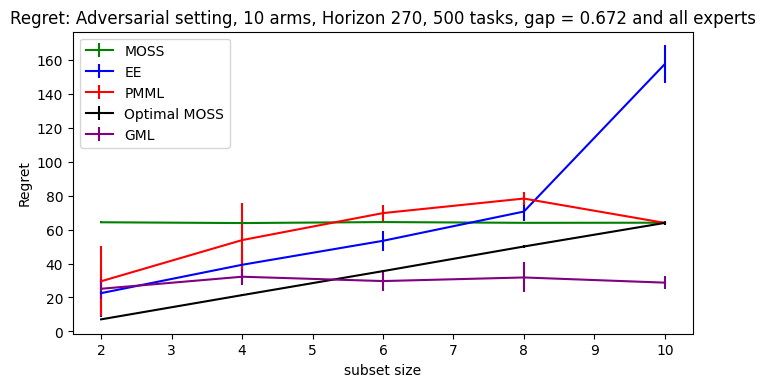

In [8]:
(X_e, regret_dict_e, title, xlabel, ylabel) = utils.subset_exp(N_EXPS, 
                                  N_TASKS, N_ARMS, HORIZON, 
                                  opt_size_list = np.arange(2,N_ARMS+1,2), **kwargs)
pickle.dump(regret_dict_e, open("results/subset.p", "wb"))
regret_dict_h = pickle.load(open("results/subset.p", "rb"))
pass

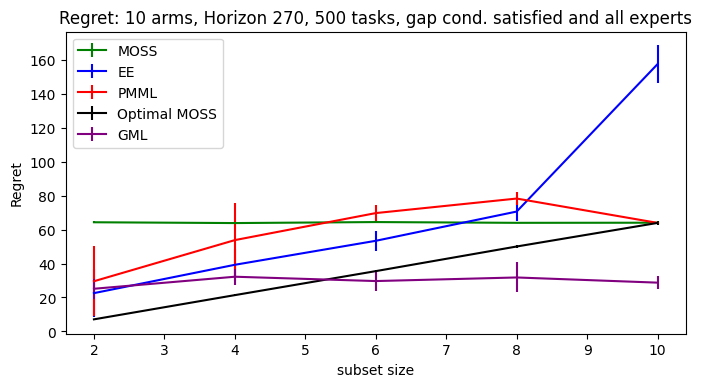

In [10]:
# Plot from loaded cache file
title=f'Regret: {N_ARMS} arms, Horizon {HORIZON}, {N_TASKS} tasks, gap cond. satisfied and all experts'
xlabel, ylabel = 'subset size', 'Regret'
X_e = np.arange(2,N_ARMS+1,2)
regret_dict_e = pickle.load(open("results/subset.p", "rb"))
utils.plot(X_e, regret_dict_e, title, xlabel, ylabel, **kwargs)